# Аспектный анализ тональности текстов

 На сегодняшнем семинаре мы рассмотрим задачу анализа тональности текстов на примерах отзывов об автомобилях, и для этого мы будем использовать датасет, который предлагался участникам соревнования SentiRuEval-2015[1]. 

* [1] https://github.com/nlpub/pymystem3
* [2] SentiRuEval2015
* [3] https://rusvectores.org/ru/models/

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (51/51), done.
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 1.7 MB 8.9 MB/s 
     |████████████████████████████████| 24.2 MB 82.5 MB/s 
     |████████████████████████████████| 6.0 MB 47.9 MB/s 
     |████████████████████████████████| 304 kB 41.8 MB/s 
     |████████████████████████████████| 181 kB 56.0 MB/s 
     |████████████████████████████████| 451 kB 55.6 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 628 kB 58.7 MB/s 
     |████████████████████████████████| 10.1 MB 32.7 MB/s 
     |████████████████████████████████| 8.2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

## Оригинальная разметка


In [11]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_sentiments = './stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'

In [12]:
from dlnlputils.sentiment_utils import parse_xml_sentiment, parse_xml_aspect, show_markup

тексты с разметкой аспектов и тональностей: 

In [13]:
texts_w_sentiment_spans = parse_xml_sentiment(xml_sentiments)
texts_w_aspect_spans    = parse_xml_aspect(xml_sentiments)

In [14]:
amount = len(texts_w_sentiment_spans)

print('Загружено {} текстов с разметкой тональности\n'.format(amount))

Загружено 217 текстов с разметкой тональности



##### выберем 2 текста, на которых будем рассматривать все примеры:

In [15]:
random_picks = [random.randint(0,amount-1) for _ in range(0,2)]

####  тональность (sentiment)

Содержимое этих файлов выглядит следующим образом: в отзыве присутствует разметка, в которой выделены ключевые слова в тексте, означающие позитивную, нейтральную или негативную оценку. Например, "просторный багажник" — это пример позитивной оценки в отзыве об автомобиле. А такие слова, как "руль закрывает обзор" — это явно негативная часть отзыва. Также, помимо тональности, у нас есть аспекты — категории, которые упомянуты в отзыве. Посмотрим, как они выглядят. Помимо тональной разметки в датасете также содержится аспектная разметка. Проще говоря, в отзывах есть некие аспекты или категории, о которых написан отзыв, например — "общее впечатление" об автомобиле, "надёжность"

In [16]:
for rand_i in random_picks:
    text, spans = texts_w_sentiment_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 107


Текст №: 76


####  Аспекты (aspects)



In [ ]:
for rand_i in random_picks:
    text,spans = texts_w_aspect_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 76


BoxMarkup('Сегодня я купил машину лада гранта и ни как не могу ее продать начнем с покупки машина мне обошлась в четыреста восемдесят тысяч рублей на реканий на машину нет стоимость масла 850 рублей замена бампера 5000 рублей если собираетесь делать ремонт машины капитально, то стоимость обойдется в районе 200000 рублей мощьность у нее 100 лошадей макс скорость 185 км в час. Общее впечатление : замечательный автомобиль',
          [Span(16, 34, 'Whole'),
           Span(80, 86, 'Costs'),
           Span(129, 135, 'Costs'),
           Span(150, 156, 'Whole'),
           Span(161, 176, 'Costs'),
           Span(208, 214, 'Costs'),
           Span(239, 252, 'Costs'),
           Span(268, 277, 'Costs'),
           Span(311, 320, 'Driveability'),
           Span(331, 338, 'Driveability'),
           Span(339, 352, 'Driveability'),
           Span(401, 411, 'Whole')])

Текст №: 43


BoxMarkup('Начну с того, что на Тойоте Хайс работает мой муж и уже давненько. Поначалу машинка очень понравилась и внешне, и внутренне. Муж был просто в восторге, что его по работе пересадили с Баргузина на Хайс, и не замечал недостатков в этой машине. А так как он периодически отвозит меня на работу и забирает с работы на ней, то и я волей-неволей столкнулась с этой машиной. Конечно, после Баргузина Хайс казался просто нереальной машиной. И удобство кресел в салоне, и плавность хода, и внешний вид, всё приводило в восторг. Муж даже начал бредить идеей, что для нашей большой семьи (у нас трое деток) покупка такой машины в семью будет идеальной. Даже в мечтах обрисовывал, как он переделает салон под междугородние путешествия всей семьёй. Но прошло уже года три-четыре, как он работает на Тойоте Хайс. Сейчас могу сказать только одно: машина ужасная до безобразия. В этом мы убедились оба. Начну с того, что проживаем мы в северном районе нашей страны, и, соответственно, машина эксплуатируется зимой при довольно низких температурах. Так вот, в зимний период салон прогревается только в зоне передних сидений (водителя и пассажира), и то кое-как. В самом салоне машина не прогревается, несмотря на дополнительные печки и всевозможные регуляторы температуры нагрева. Так же зимой на поворотах (например, на перекрёстке) очень сильно заносит заднюю часть автомобиля. Ну это понятно - задний привод и всё остальное прочее. Но заносы эти, даже глядя со стороны, приводят в тихую жуть. Хайсов по городу бегает достаточное количество и регулярно наблюдается картина с этими заносами. Дверь на салазках снаружи открывается ужасно - женская половина пассажиров, в том числе и я, регулярно ломают ногти, так как ручка сделана не очень хорошо и с неё постоянно соскальзывают пальцы. В водительской части салона в принципе всё довольно неплохо, за исключением торпеды, которая после недолгой эксплуатации автомобиля начала греметь, что само по себе уже не приятно. Да и сам кузов Хайса начал скрипеть, чем сразу заслужил гордое звание "Сарай". Сервисное обслуживание в Тойота-центре нашего города тоже ниже плинтуса. Машина хоть и обслуживается за счёт организации, но после каждого ТО мой муж, мягко говоря, в шоке от того, как сервис-менеджеры каждый раз находят на ровном месте какие-то "болячки" у машины, дабы содрать побольше денег. А те поломки, которые действительно требуют серьёзного внимания, в заказ-наряде прописываются, но специалисты даже и не заглядывают туда. Таким образом, мой муж половину этой зимы проездил с "инвалидным" задним правым колесом: с места тронуться было невозможно - оно просто не крутилось, приходилось его срывать. Вобщем, впечатление от Хайса не айс (прям каламбур получился). Внешне, да, выглядит красиво и величественно. Но на самом деле такой же "сарай" как Баргузин, Газель и прочее. Одно, что кочки пятой точкой не чувствуешь :) За такую цену ожидаешь лучшего качества. ',
          [Span(21, 32, 'Whole'),
           Span(76, 83, 'Whole'),
           Span(104, 110, 'Appearance'),
           Span(183, 192, 'Whole'),
           Span(196, 200, 'Whole'),
           Span(234, 240, 'Whole'),
           Span(359, 366, 'Whole'),
           Span(383, 392, 'Whole'),
           Span(393, 397, 'Whole'),
           Span(424, 431, 'Whole'),
           Span(435, 443, 'Comfort'),
           Span(444, 459, 'Comfort'),
           Span(463, 477, 'Driveability'),
           Span(481, 492, 'Appearance'),
           Span(610, 616, 'Whole'),
           Span(687, 692, 'Comfort'),
           Span(786, 797, 'Whole'),
           Span(832, 838, 'Whole'),
           Span(969, 975, 'Whole'),
           Span(1057, 1062, 'Comfort'),
           Span(1063, 1075, 'Comfort'),
           Span(1090, 1106, 'Comfort'),
           Span(1160, 1166, 'Comfort'),
           Span(1167, 1182, 'Comfort'),
           Span(1211, 1216, 'Comfort'),
           Span(1232, 1262, 'Comfort'),
           Span(1277, 1289, 'Driveability'),
           Span(1330, 1337, 'Driveability'),
           Sp

## BIO-тэги для обучения модели

На основе оригинальной разметки к данному датасету мы подготовили BIO-разметку, чтобы размеченный таким образом датасет можно было подавать на вход нашей нейросети. Как можно видеть на двух примерах на экране, мы добавили тэг "OTHER" для всех слов, которые не относятся к аспектам или тональности, объединили в сущности, стоящие рядом. Результат вы видите сами. Мы выделили все куски текста, которые были вне оригинальной разметки (например, вот эти два), также (в этих кусках) сделали деление на слова и, наконец, добавили BIO-тэги размеченных в оригинале элементов. А, как вы помните, BIO-тэг — это b — beginning (начало), i — inside (внутри), и о — other (для всего, что не важно для задачи).

In [20]:
from dlnlputils.sentiment_utils import fill_gaps, extract_BIO_tagged_tokens

In [21]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]
    cover_spans       = fill_gaps(text, aspect_spans)
    
    print('Полное покрытие разметкой текста №:',rand_i) 
    show_markup(text, cover_spans)

Полное покрытие разметкой текста №: 107


Полное покрытие разметкой текста №: 76


### Разбиение текста на предложения, а предложений - на слова.

In [22]:
from dlnlputils.sentiment_utils import regex_sentence_detector, sentence_spans,sentence_splitter

In [23]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [24]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]

    print('Разбиение на предложения и BIO токенизация текста №:',rand_i) 
    for sentence, spans in sentence_splitter(text, aspect_spans):

        cover_spans      = fill_gaps(sentence,spans)
        tokens_w_biotags = extract_BIO_tagged_tokens(sentence, 
                                                     cover_spans, 
                                                     word_tokenizer.tokenize)

        show_markup(sentence, cover_spans)
        print(tokens_w_biotags[:10],'\n')

Разбиение на предложения и BIO токенизация текста №: 107


[('Хороший', 'Other'), ('немец', 'B-Whole'), (',', 'Other'), ('это', 'Other'), ('легендарный', 'Other'), ('автомобиль', 'B-Whole')] 



[('под', 'B-Driveability'), ('капотом', 'I-Driveability'), ('v8', 'Other'), ('c', 'Other'), ('двумя', 'Other'), ('надувами', 'B-Driveability'), (',', 'Other'), ('500л', 'Other'), ('.', 'Other')] 



[('с', 'Other'), ('.', 'Other')] 



[('хорошие', 'Other'), ('показатели', 'Other'), ('для', 'Other'), ('гонок', 'Other'), (',', 'Other'), ('но', 'Other'), ('и', 'Other'), ('проходимость', 'B-Driveability'), ('у', 'Other'), ('него', 'Other')] 



[('Салон', 'B-Comfort'), ('не', 'Other'), ('очень', 'Other'), ('.', 'Other')] 



[('задние', 'B-Comfort'), ('сиденья', 'I-Comfort'), ('не', 'B-Comfort'), ('регулируются', 'I-Comfort'), ('совсем', 'Other'), ('.', 'Other')] 



[('передние', 'B-Comfort'), ('сиденья', 'I-Comfort'), ('регулируются', 'B-Comfort')] 



[('Общее', 'Other'), ('впечатление', 'Other'), (':', 'Other'), ('хорошее', 'Other')] 

Разбиение на предложения и BIO токенизация текста №: 76


[('Сегодня', 'Other'), ('я', 'Other'), ('купил', 'Other'), ('машину', 'B-Whole'), ('лада', 'I-Whole'), ('гранта', 'I-Whole'), ('и', 'Other'), ('ни', 'Other'), ('как', 'Other'), ('не', 'Other')] 



[('Общее', 'Other'), ('впечатление', 'Other'), (':', 'Other'), ('замечательный', 'Other'), ('автомобиль', 'B-Whole')] 



##  Подготовка данных для обучения: 

In [46]:
from dlnlputils.sentiment_utils import prepare_data, form_vocabulary_and_tagset

In [47]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_train = './stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = './stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

### Токенизация: 

In [48]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)


#### разбиение на предложения дало нам столько коротких текстов:

In [49]:
len(training_data), len(test_data)

(2210, 1922)

In [50]:
all_data = training_data + test_data

In [51]:
vocabulary,labels = form_vocabulary_and_tagset(all_data)

In [52]:
labels

{'B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other'}

#### а размер словаря:

In [53]:
len(vocabulary), len(labels)

(11333, 15)

#### индексация:

In [54]:
from dlnlputils.sentiment_utils import Converter, generate_markup

In [55]:
converter = Converter(vocabulary,labels)

In [56]:
test_recipe, test_tags = training_data[1211]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(decoded_recipe, decoded_tags) 

show_markup(text, spans)

tensor([ 1395,  7307, 10381,  3591,  6303,  2877,  6524,  6847,  7826,   289,
         8063,  9912,  8648,  5768,  6381,   823,  7653,  6064,  7835,   289,
         5435,  3739,  2737,  9234,   289,  5331,   289,  2540,   289,  9247])
tensor([14, 14, 14, 14, 14, 14,  4, 11, 11, 14, 14, 14, 14, 14,  4, 14,  4, 11,
        11, 14,  4, 11, 11, 11, 14,  4, 14,  4, 14,  4])



### Нейросети

In [39]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

###  Предобученные векторы слов

Алгоритм fastText обученный на корпусе Тайга, смотрите подробности на сайте: https://rusvectores.org/ru/models/


In [40]:
# !pip3 install wget

In [57]:
import zipfile
import gensim
import wget

model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
wget.download(model_url)
model_file = './stepik-dl-nlp/datasets/' + model_url.split('/')[-1]

А теперь перейдём к нейросетевому алгоритму. На этот раз мы воспользуемся векторами слов из датасета RusVectores с одноимённого сайта, подготовленного с помощью алгоритма FastText. В предобученной модели FastText, наверное, присутствуют следующие слова: "тачка", "двигатель" и "Audi". Посмотрим, какие векторы являются ближайшими к векторам этих слов. Например, к слову "двигатель" ближайшие векторы — "двигатели" 

In [59]:
w2v_model = gensim.models.KeyedVectors.load('./stepik-dl-nlp/datasets/187/model.model')

words = ['тачка', 'двигатель', 'ауди']

for word in words:
    #if word in w2v_model:
           
    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')
    
    #else: print(word + ' is not present in the model')

FileNotFoundError: ignored

In [ ]:
numpy_embeddings = np.zeros(shape=[VOCAB_SIZE, EMBEDDING_DIM],dtype=np.float32)

for word in vocabulary:
    #if word in w2v_model:
    vector = w2v_model.get_vector(word)
    index  = converter.words_to_index([word])
    numpy_embeddings[index] = vector
        
    #else: print(word + ' - такого слова нет в модели fasttext')
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([11333, 300])

### LSTM 

1. Использует предобученные вектора слов и не изменяет их
2. Двунаправленная



Из всего множества векторов FastText мы возьмём только 11 333 вектора, соответствующие всем словам в нашем датасете, и поместим их в embedding матрицу. Далее мы определим нейросети LSTM, которая будет использовать эти векторы. Предобученные векторы мы передаём отдельным аргументом в метод init и — обратите внимание — говорим, что, во время обучения нейросети LSTM, она не должна дообучать наши пребодученные векторы. Это позволит нейросети сконцентрироваться на обучении собственных компонент. Вторая деталь, на которую я бы хотел обратить внимание — то, что теперь мы используем двунаправленную нейросеть и она будет работать следующим образом. Как всегда, слова попадают в объект "конвертер" и для них происходит замена индекса. В матрице эмбеддингов алгоритм находит векторы этих слов. Они, в свою очередь, попадают в LSTM. Но теперь это двунаправленная модель, и она также будет двигаться по предложению в обратном направлении. 

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

### Взвешеная функция потерь

In [ ]:
from collections import Counter

tag_counter = Counter()
for _,tokens in training_data:
    for token in tokens:
        tag_counter[token]+=1
        
tag_counter.most_common()     

[('Other', 23529),
 ('B-Driveability', 1188),
 ('B-Comfort', 1092),
 ('I-Driveability', 773),
 ('B-Reliability', 769),
 ('B-Whole', 768),
 ('I-Comfort', 480),
 ('I-Reliability', 457),
 ('B-Costs', 392),
 ('B-Appearance', 354),
 ('I-Whole', 310),
 ('I-Costs', 177),
 ('I-Appearance', 146),
 ('B-Safety', 87),
 ('I-Safety', 63)]

In [ ]:
class_weights = torch.ones(15)
class_divs    = torch.ones(15)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))


class_weights /= class_divs


print(class_weights.detach())

tensor([ 66.7812,  21.6488,  60.3075,  19.8994,  30.7419, 271.7303,  30.7819,
        161.9215,  49.2511, 133.5623,  30.5828,  51.7298, 375.2466,  76.2598,
          1.0047])


Следующая модификация, которая позволит нам добиться высоких результатов при аспектной классификации — это взвешенная функция потерь. Из приведённой статистики мы видим, что тэг "other" встречается довольно часто (я бы сказал, почти всегда), а тэг "внешний вид" и тэг "безопасность" встречаются довольно редко. Мы хотим, чтобы взвешенная функция потерь сильнее штрафовала нашу нейросеть за ошибки при предсказании этих редких тэгов. 

In [ ]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE, pretrained_embeddings)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

#### training

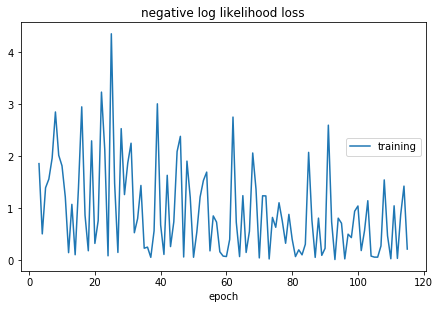

negative log likelihood loss:
training   (min:    0.011, max:    4.351, cur:    0.211)


In [ ]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(5): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        tag_scores     = model(encoded_recipe)
        
        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 100 == 0:
            liveplot.update({'negative log likelihood loss': loss})
            liveplot.draw()
            

In [ ]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре

    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

In [ ]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


BoxMarkup('Вот из чего им удалось сделать конфетку так это из небольших коммерческих автомобилей , но вот уже Fiat Ducato вечный аутсайдер среди больших автобусов , по дизайну видно , что Fiat Ducato пытается скопировать Peouget Boxer , фары и форма одни и те же во всяком случае и если поставить их рядом друг с другом , то особой разницы во внешности не будет , однако в начинке , Мы все знаем , что Французы пока еще впереди , да и по цене лям достаточно накладно отдавать за аутсайдера .',
          [Span(0, 60, 'Other'),
           Span(61, 85, 'Whole'),
           Span(86, 98, 'Other'),
           Span(99, 110, 'Whole'),
           Span(111, 156, 'Other'),
           Span(157, 164, 'Appearance'),
           Span(165, 176, 'Other'),
           Span(177, 188, 'Appearance'),
           Span(189, 209, 'Other'),
           Span(210, 223, 'Appearance'),
           Span(224, 225, 'Other'),
           Span(226, 230, 'Appearance'),
           Span(231, 232, 'Other'),
           Span(233, 238, 'Appearance'),
           Span(239, 331, 'Other'),
           Span(332, 341, 'Appearance'),
           Span(342, 361, 'Other'),
           Span(362, 369, 'Driveability'),
           Span(370, 426, 'Other'),
           Span(427, 431, 'Costs'),
           Span(432, 446, 'Other'),
           Span(447, 455, 'Costs'),
           Span(456, 480, 'Other')])

предсказанные тэги:


BoxMarkup('Вот из чего им удалось сделать конфетку так это из небольших коммерческих автомобилей , но вот уже Fiat Ducato вечный аутсайдер среди больших автобусов , по дизайну видно , что Fiat Ducato пытается скопировать Peouget Boxer , фары и форма одни и те же во всяком случае и если поставить их рядом друг с другом , то особой разницы во внешности не будет , однако в начинке , Мы все знаем , что Французы пока еще впереди , да и по цене лям достаточно накладно отдавать за аутсайдера .',
          [Span(0, 47, 'Other'),
           Span(48, 50, 'Whole'),
           Span(51, 60, 'Other'),
           Span(61, 87, 'Whole'),
           Span(88, 90, 'Other'),
           Span(91, 94, 'Whole'),
           Span(95, 98, 'Other'),
           Span(99, 110, 'Whole'),
           Span(111, 117, 'Driveability'),
           Span(118, 127, 'Whole'),
           Span(128, 141, 'Other'),
           Span(142, 151, 'Whole'),
           Span(152, 156, 'Other'),
           Span(157, 170, 'Appearance'),
           Span(171, 176, 'Other'),
           Span(177, 181, 'Comfort'),
           Span(182, 197, 'Other'),
           Span(198, 209, 'Appearance'),
           Span(210, 238, 'Whole'),
           Span(239, 331, 'Other'),
           Span(332, 341, 'Appearance'),
           Span(342, 408, 'Other'),
           Span(409, 416, 'Driveability'),
           Span(417, 426, 'Other'),
           Span(427, 435, 'Costs'),
           Span(436, 446, 'Other'),
           Span(447, 455, 'Reliability'),
           Span(456, 480, 'Other')])


истинные тэги:


BoxMarkup('В общем , ребят , подведу итог , не берите себе данный автомобиль ! Общее впечатление : Отечественный автомобиль -погремушка',
          [Span(0, 54, 'Other'),
           Span(55, 65, 'Whole'),
           Span(66, 101, 'Other'),
           Span(102, 124, 'Comfort')])

предсказанные тэги:


BoxMarkup('В общем , ребят , подведу итог , не берите себе данный автомобиль ! Общее впечатление : Отечественный автомобиль -погремушка',
          [Span(0, 47, 'Other'),
           Span(48, 65, 'Whole'),
           Span(66, 87, 'Other'),
           Span(88, 124, 'Whole')])


истинные тэги:


BoxMarkup('Автомобиль был куплен в апреле 2010 года в салоне Тагаз .',
          [Span(0, 10, 'Whole'), Span(11, 57, 'Other')])

предсказанные тэги:


BoxMarkup('Автомобиль был куплен в апреле 2010 года в салоне Тагаз .',
          [Span(0, 10, 'Whole'),
           Span(11, 42, 'Other'),
           Span(43, 49, 'Comfort'),
           Span(50, 55, 'Whole'),
           Span(56, 57, 'Other')])


истинные тэги:


BoxMarkup('У меня был Ваз 2112 2006 .',
          [Span(0, 10, 'Other'), Span(11, 19, 'Whole'), Span(20, 26, 'Other')])

предсказанные тэги:


BoxMarkup('У меня был Ваз 2112 2006 .',
          [Span(0, 10, 'Other'),
           Span(11, 19, 'Whole'),
           Span(20, 24, 'Other'),
           Span(25, 26, 'Whole')])


истинные тэги:


BoxMarkup('Одним словом заливай бензин , проходи ТО и катайся в своё удовольствие ! Общее впечатление : Хороший , качественный автомобиль без изысков',
          [Span(0, 20, 'Other'),
           Span(21, 27, 'Driveability'),
           Span(28, 37, 'Other'),
           Span(38, 40, 'Reliability'),
           Span(41, 102, 'Other'),
           Span(103, 115, 'Reliability'),
           Span(116, 126, 'Whole'),
           Span(127, 138, 'Other')])

предсказанные тэги:


BoxMarkup('Одним словом заливай бензин , проходи ТО и катайся в своё удовольствие ! Общее впечатление : Хороший , качественный автомобиль без изысков',
          [Span(0, 12, 'Other'),
           Span(13, 27, 'Driveability'),
           Span(28, 29, 'Other'),
           Span(30, 37, 'Driveability'),
           Span(38, 42, 'Other'),
           Span(43, 50, 'Reliability'),
           Span(51, 102, 'Other'),
           Span(103, 126, 'Whole'),
           Span(127, 130, 'Driveability'),
           Span(131, 138, 'Other')])


истинные тэги:


BoxMarkup('Салон комфортный насколько может быть комфортный авто за эти деньги',
          [Span(0, 16, 'Comfort'),
           Span(17, 37, 'Other'),
           Span(38, 53, 'Comfort'),
           Span(54, 60, 'Other'),
           Span(61, 67, 'Costs')])

предсказанные тэги:


BoxMarkup('Салон комфортный насколько может быть комфортный авто за эти деньги',
          [Span(0, 26, 'Comfort'),
           Span(27, 37, 'Other'),
           Span(38, 48, 'Comfort'),
           Span(49, 53, 'Whole'),
           Span(54, 56, 'Other'),
           Span(57, 60, 'Whole'),
           Span(61, 67, 'Costs')])


истинные тэги:


BoxMarkup('Расход бензина маленький - 7 .5 литров на 100 километров .',
          [Span(0, 14, 'Driveability'), Span(15, 58, 'Other')])

предсказанные тэги:


BoxMarkup('Расход бензина маленький - 7 .5 литров на 100 километров .',
          [Span(0, 14, 'Driveability'), Span(15, 58, 'Other')])


истинные тэги:


BoxMarkup('Есть один нюанс .', [Span(0, 17, 'Other')])

предсказанные тэги:


BoxMarkup('Есть один нюанс .', [Span(0, 17, 'Other')])


истинные тэги:


BoxMarkup('иначе сильная вибрация по кузову , вместе с ней сразу стоит поменять и остальные подушки , это еще 3 т .',
          [Span(0, 13, 'Other'),
           Span(14, 32, 'Comfort'),
           Span(33, 80, 'Other'),
           Span(81, 88, 'Reliability'),
           Span(89, 104, 'Other')])

предсказанные тэги:


BoxMarkup('иначе сильная вибрация по кузову , вместе с ней сразу стоит поменять и остальные подушки , это еще 3 т .',
          [Span(0, 5, 'Other'),
           Span(6, 13, 'Safety'),
           Span(14, 25, 'Driveability'),
           Span(26, 32, 'Reliability'),
           Span(33, 80, 'Other'),
           Span(81, 88, 'Safety'),
           Span(89, 104, 'Other')])


истинные тэги:


BoxMarkup('Сев за руль я сразу почувствовала не удобные сидения , заводится хорошо и трогается тоже , но когда я прокатилась я поняла что машина деревянная в каком смысле объясню .',
          [Span(0, 33, 'Other'),
           Span(34, 52, 'Comfort'),
           Span(53, 54, 'Other'),
           Span(55, 64, 'Reliability'),
           Span(65, 73, 'Other'),
           Span(74, 83, 'Driveability'),
           Span(84, 126, 'Other'),
           Span(127, 144, 'Driveability'),
           Span(145, 169, 'Other')])

предсказанные тэги:


BoxMarkup('Сев за руль я сразу почувствовала не удобные сидения , заводится хорошо и трогается тоже , но когда я прокатилась я поняла что машина деревянная в каком смысле объясню .',
          [Span(0, 19, 'Other'),
           Span(20, 33, 'Safety'),
           Span(34, 52, 'Comfort'),
           Span(53, 54, 'Other'),
           Span(55, 64, 'Reliability'),
           Span(65, 126, 'Other'),
           Span(127, 133, 'Whole'),
           Span(134, 144, 'Comfort'),
           Span(145, 169, 'Other')])

### Статистика

##### 1.  Количество верно предсказанных тэгов:

In [ ]:
from dlnlputils.sentiment_utils import tag_statistics

In [ ]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для Other:
  корректно:	 15840
      всего:	 19922
% корректно:	 79.51008934845899

для B-Whole:
  корректно:	 527
      всего:	 673
% корректно:	 78.30609212481427

для B-Driveability:
  корректно:	 488
      всего:	 1066
% корректно:	 45.77861163227016

для I-Driveability:
  корректно:	 290
      всего:	 711
% корректно:	 40.787623066104075

для B-Appearance:
  корректно:	 174
      всего:	 275
% корректно:	 63.272727272727266

для I-Appearance:
  корректно:	 32
      всего:	 100
% корректно:	 32.0

для B-Reliability:
  корректно:	 305
      всего:	 809
% корректно:	 37.7008652657602

для I-Whole:
  корректно:	 87
      всего:	 213
% корректно:	 40.845070422535215

для B-Comfort:
  корректно:	 610
      всего:	 1067
% корректно:	 57.16963448922212

для I-Comfort:
  корректно:	 190
      всего:	 497
% корректно:	 38.22937625754527

для I-Reliability:
  корректно:	 147
      всего:	 475
% корректно:	 30.94736842105263

для B-Costs:
  корректно:	 2

##### 2.  Количество верно предсказанных тэгов в виде матрицы ошибок:

In [ ]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

In [ ]:
y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, converter, sentence)
    y_true += tags

Наша нейросеть завершила обучение, мы можем проверить её точность на тестовых и тренировочных данных. Для этого мы опять построим матрицу ошибок и посмотрим на статистику. Определим уже известную вам функцию "predict_tags". Посмотрим на 10 случайных предложений из тестового датасета — как их будет размечать наша нейросеть. На тренировочных данных матрица ошибок выглядит хорошо. Матрица ошибок, полученная на тестовом датасете, выглядит не так хорошо, как на датасете, на котором мы обучались. Это может быть связано с тем, что, например, в целом, наши датасеты довольно небольшие — это 200 текстов, в каждом по 2000 предложений и, возможно, нам нужно было ещё немного модифицировать функцию потерь, чтобы не так агрессивно взвешивать тэги.

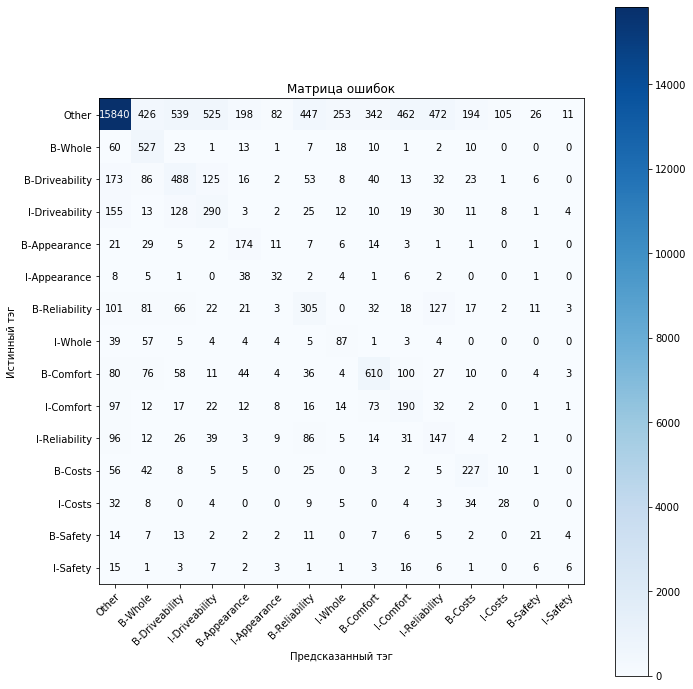

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

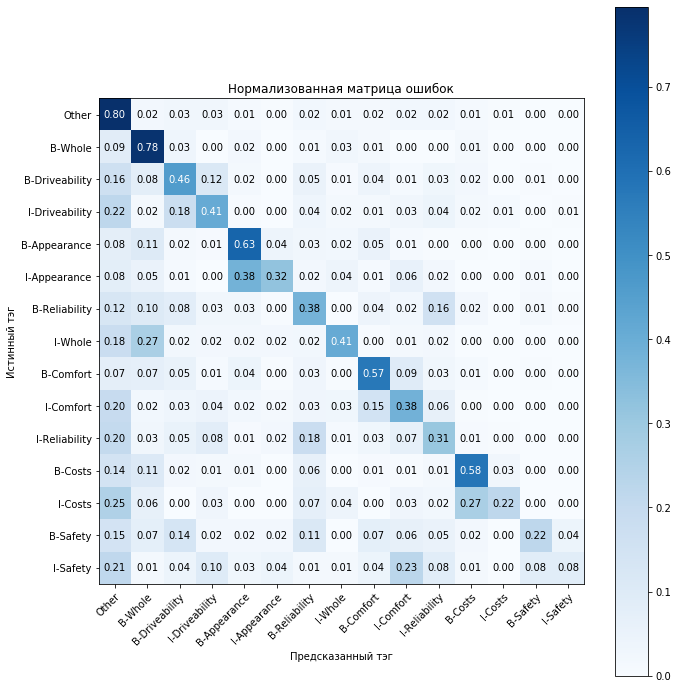

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()